# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

## The data represents 17 marketing campaigns that occurred between May 2008 and November 2010

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score,classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve
from scipy.stats import uniform, randint
from IPython.display import Image, display

In [3]:
campaign_customer_data = pd.read_csv('bank-additional-full.csv', sep = ';')

In [4]:
campaign_customer_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
# Exploration and running stats
print(campaign_customer_data.describe())
print(campaign_customer_data.describe(include=['object']))

               age      duration      campaign         pdays      previous   
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000  \
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198    

# I looked at box plots and bar charts to determine the data distribution, data consolidation and clean up data. I have commented out those plots to keep the size of the file low.

## Observations from pie chart of positive and negative outcome distribution
- Only 11% of the data has positive outcome, hence need to generate model that would precisely identify the customers who would reject the offer

## Observations from box and whiskers plot 
- above age 79 for outcome "yes" are outliers hence need to drop that data
- above 1480 seconds of contact duration is an outlier

## Observations from the bar graph

- drop the data with "unknown" job
- drop the data with "unknown" marital status
- drop the data with "unknown" education
- drop the data with "unknown" default
- drop the data with "unknown" housing
- drop the column "contact" as that does not seem to be influencing the outcome
- drop the column "pdays" as most people in this dataset were not contacted before'
- drop the duration column as it truly influences the model.

## Social and Economic attribute influence
- Most outcomes were "no" at a higher inflation rate(consumer price index)
- Most outcomes were "no" as the employment rate increased - could mean that either people did not have much time to think over the offering or their economic condition improved so they did not think much about making a bit more money through the offering
- Most outcomes were "no" at a higher Euribor rate which often signals tightening monetary policy or stress in the banking system

## Data Consolidation and conversion
- Consolidating the retired and enemployed category
- Consolidating housemaid job as blue-collar and admin, management jobs ad white-collar
- Consolidating entrepreneur as self-employed
- Consolidating basic and illiterate categories in to basic
- Converted month and days of week to numeric data
- Combining the housing and personal loan to loan column

## Data Grouping
- Grouped Ages in to buckets 10-19, 20-29 and so on to get better results as to which age group is most likely to accept the offer

## Adjustments after initial runs
- The nr.employed: number of employees is ambiguous data and seems to be influencing the models, decided to drop it
- Based on the stacked graph of previous number of contacts and corresponding success and failures, decided to drop previous number of contacts as most of the customers were not contacted previously and the decision to accept/reject the deposit did not seem to depend on the number of contacts

In [10]:
# Group the data by the Y column which indicates if the offer was accepted or rejected,get the size of each of the Y options and reset the index
data_proportion_accept= (campaign_customer_data.groupby('y').size().reset_index())
# Create a Proportion column which will contain the proportion of each of the Y options
data_proportion_accept["Proportion"] = data_proportion_accept.iloc[:, 1] /len(campaign_customer_data)
data_proportion_accept["y"] = data_proportion_accept["y"].astype(str)
#Draw a pie chart
fig = px.pie(data_proportion_accept, values='Proportion',names='y', title='Deposit Offer Accept/Reject Distribution')
fig.update_traces(labels=['Rejected Offers', 'Accepted Offers'])
fig.show()
# Only 11% of the data has positive outcome, hence need to generate model that would precisely identify the customers who would reject the offer

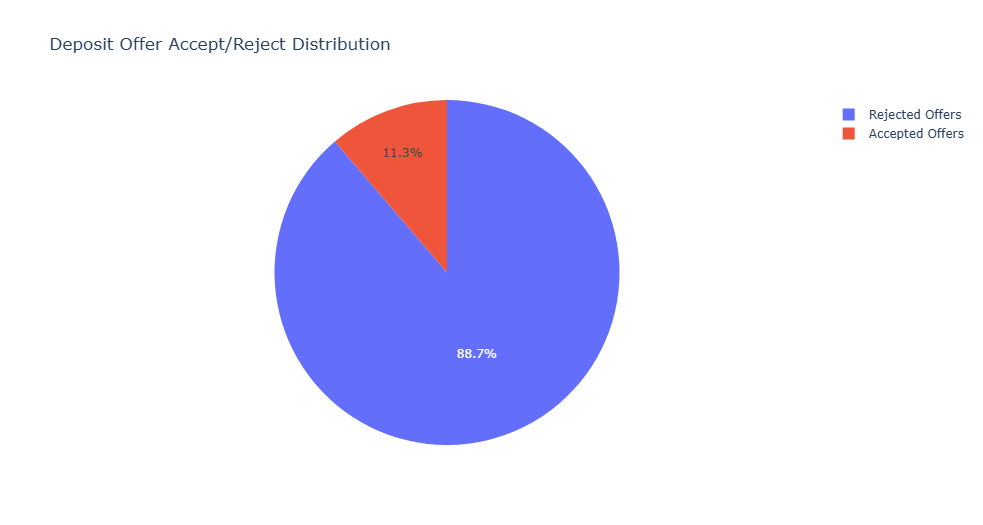

In [40]:
display(Image(filename='./piechart.png'))

In [8]:
#Most of the customers were not contacted previously and the decision to accept/reject the deposit did not seem to depend on the number of contacts
fig = px.bar(campaign_customer_data['previous'].value_counts().sort_index())
fig.show()

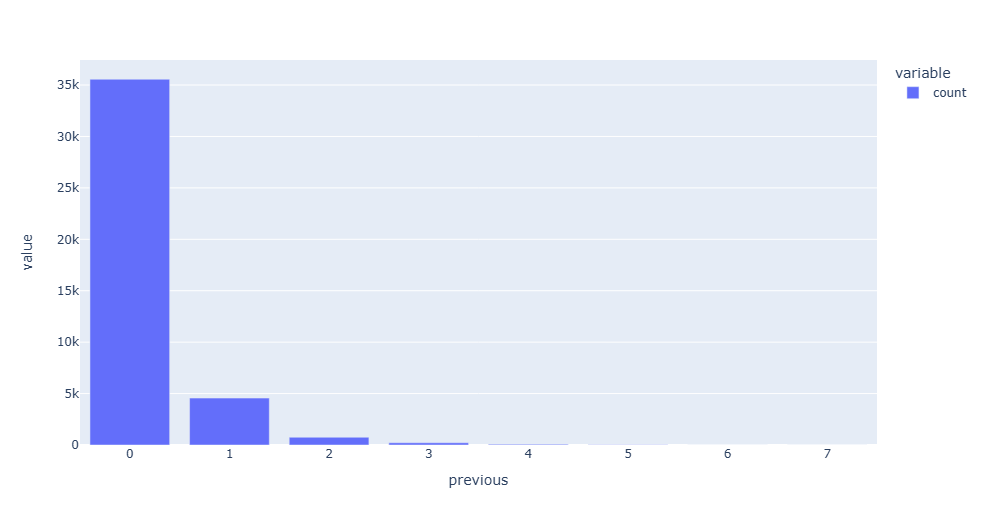

In [41]:
display(Image(filename='./barchart.png'))

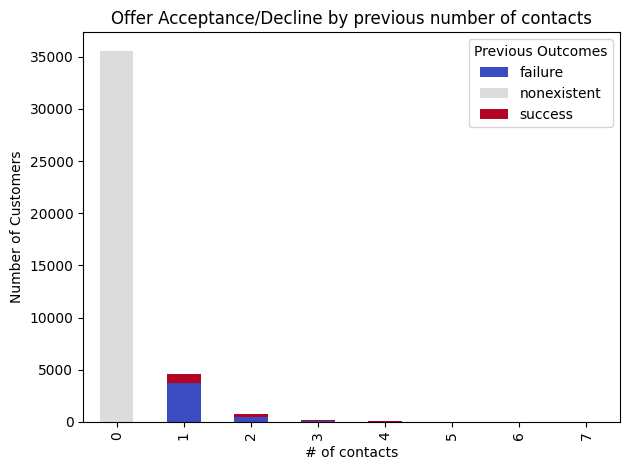

In [9]:
grouped = campaign_customer_data.groupby(['previous','poutcome']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Offer Acceptance/Decline by previous number of contacts')
plt.xlabel('# of contacts')
plt.ylabel('Number of Customers')
plt.legend(title='Previous Outcomes')
plt.tight_layout()
plt.show()

In [11]:
#Outliers for age
px.box(campaign_customer_data, y="age",color="y")

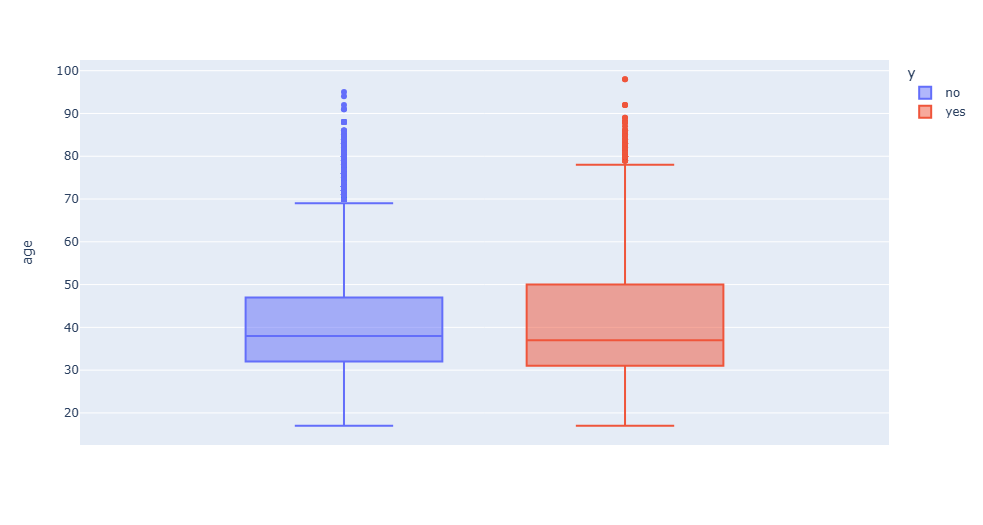

In [42]:
display(Image(filename='./boxplot.png'))

In [158]:
#Outliers for pdays
#px.box(campaign_customer_data, y="pdays",color="y")

In [12]:
#Distribution of eductaion of the participants
px.box(campaign_customer_data, y="education",color="y")

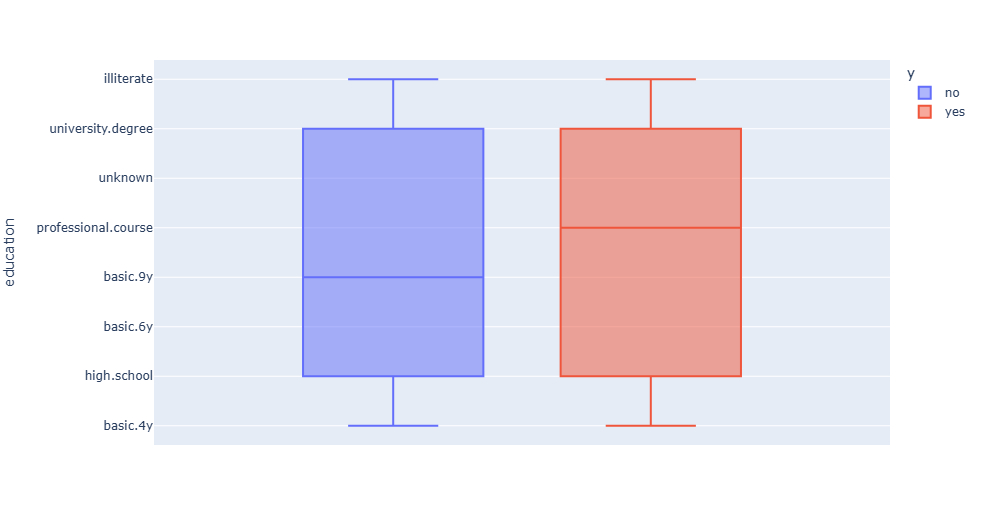

In [43]:
display(Image(filename='./boxplot_2.png'))

In [160]:
#Determine how is monthy distribution of positive outcomes
grouped = campaign_customer_data.query('y=="yes"')['month'].value_counts().sort_index()
grouped

month
apr    539
aug    655
dec     89
jul    649
jun    559
mar    276
may    886
nov    416
oct    315
sep    256
Name: count, dtype: int64

In [13]:
#Distribution of job amongst the participants
fig = px.bar(campaign_customer_data.query('y == "yes"')['job'].value_counts().sort_index())
fig.show()

In [14]:
#fig = px.bar(campaign_customer_data.query('y == "yes"')['education'].value_counts().sort_index())
#fig.show()

In [15]:
# Data cleanup and consolidation based on the above analysis
campaign_customer_data.loc[campaign_customer_data['housing'] == 'yes', 'loan'] = 'yes'
campaign_customer_data = campaign_customer_data[campaign_customer_data['age'] <80]
campaign_customer_data = campaign_customer_data[campaign_customer_data['duration'] <=1480]
campaign_customer_data = campaign_customer_data[campaign_customer_data['job'] !="unknown"]
campaign_customer_data = campaign_customer_data[campaign_customer_data['marital'] !="unknown"]
campaign_customer_data = campaign_customer_data[campaign_customer_data['education'] !="unknown"]
campaign_customer_data = campaign_customer_data[campaign_customer_data['default'] !="unknown"]
campaign_customer_data = campaign_customer_data[campaign_customer_data['housing'] !="unknown"]
campaign_customer_data.drop('contact', axis=1, inplace=True)
campaign_customer_data.drop('pdays', axis=1, inplace=True)
campaign_customer_data.drop('duration', axis=1, inplace=True)
campaign_customer_data.drop('previous', axis=1, inplace=True)
campaign_customer_data.drop('nr.employed', axis=1, inplace=True)
campaign_customer_data.drop('housing', axis=1, inplace=True)
campaign_customer_data['job'].replace(['retired'], 'unemployed', inplace=True)
campaign_customer_data['job'].replace(['entrepreneur'], 'self-employed', inplace=True)
campaign_customer_data['job'].replace(['housemaid'], 'blue-collar', inplace=True)
campaign_customer_data['job'].replace(['admin.','management'], 'white-collar', inplace=True)

In [16]:
# Consolidate the cylinder field in to a broader category
campaign_customer_data['education'].replace(['basic.4y','basic.6y','basic.9y', 'illiterate'], 'basic', inplace=True)

In [17]:
#Convert days and months to numeric format and drop the original data
day_to_num = {
    'mon': 0,
    'tue': 1,
    'wed': 2,
    'thu': 3,
    'fri': 4
}
month_to_num ={
    'jan': 0,
    'feb': 1,
    'mar': 2,
    'apr': 3,
    'may': 4,
    'jun': 5,
    'jul': 6,
    'aug': 7,
    'sep': 8,
    'oct': 9,
    'nov': 10,
    'dec': 11,
}

In [18]:
campaign_customer_data['DayNum'] = campaign_customer_data['day_of_week'].map(day_to_num)
campaign_customer_data['MonthNum'] = campaign_customer_data['month'].map(month_to_num)

In [19]:
campaign_customer_data.drop('day_of_week', axis=1, inplace=True)
campaign_customer_data.drop('month', axis=1, inplace=True)

In [20]:
# Group by the age groups and drop the Age column
campaign_customer_data['AgeGroup'] = pd.cut(campaign_customer_data['age'], bins=[10, 19, 29, 39, 49, 59,69,79], labels=['10-19','20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
                                    )
grouped = campaign_customer_data.groupby(['job', 'AgeGroup']).size().unstack(fill_value=0)
campaign_customer_data.drop('age', axis=1, inplace=True)
grouped

AgeGroup,10-19,20-29,30-39,40-49,50-59,60-69,70-79
job,,,,,,,
blue-collar,0,888,2807,1692,863,55,11
self-employed,0,248,927,586,378,28,1
services,0,610,1272,676,285,3,0
student,38,465,102,2,0,0,0
technician,0,724,2881,1227,595,23,0
unemployed,0,119,341,226,622,287,242
white-collar,0,1620,5190,2587,1480,104,8


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

## Direct Marketing Campaigns to get bank customers to invest their money can be resource expensive with the need to staff people to make phone calls. The Business Objective is to use the available data from previous campaigns to come up with a predictive model to increase the efficiency of directed campaigns for long-term deposit offer with reduced number of contacts.

## Given the data distribution, the model needs to accurately determine customers who are likely to reject the offer so they can be excluded from the direct marketing campaigns and can be reached in an alternate way - like email or website.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [21]:
campaign_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30213 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   job             30213 non-null  object  
 1   marital         30213 non-null  object  
 2   education       30213 non-null  object  
 3   default         30213 non-null  object  
 4   loan            30213 non-null  object  
 5   campaign        30213 non-null  int64   
 6   poutcome        30213 non-null  object  
 7   emp.var.rate    30213 non-null  float64 
 8   cons.price.idx  30213 non-null  float64 
 9   cons.conf.idx   30213 non-null  float64 
 10  euribor3m       30213 non-null  float64 
 11  y               30213 non-null  object  
 12  DayNum          30213 non-null  int64   
 13  MonthNum        30213 non-null  int64   
 14  AgeGroup        30213 non-null  category
dtypes: category(1), float64(4), int64(3), object(7)
memory usage: 3.5+ MB


In [22]:
#Prepping the data for the models
X = campaign_customer_data.drop(columns='y')
y = campaign_customer_data['y']

In [23]:
##Categorical and Numeric data identification for Transform 
categorical_cols = X.select_dtypes(include=['object','category']).columns
numeric_cols = X.select_dtypes(exclude=['object','category']).columns

In [25]:
# Define the preprocessor - use OneHotEncoder for categorical data and Standard Scaler for the numeric data
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [27]:
#Get the class counts
class_counts = y_train.value_counts()

# Baseline Accuracy calculation
majority_class = class_counts.idxmax()
baseline_accuracy = class_counts.max() / class_counts.sum()

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.88


## Our classifier should aim to beat the 0.88 accuracy

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [28]:
lgr_pipe = Pipeline([('transformer', preprocessor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])
start = time.time()
lgr_pipe.fit(X_train,y_train)
end = time.time()
y_lgr_train_pred = lgr_pipe.predict(X_train)
y_lgr_test_pred = lgr_pipe.predict(X_test)
lgr_train_score = accuracy_score(y_train, y_lgr_train_pred)
lgr_test_score = accuracy_score(y_test, y_lgr_test_pred)
lgr_train_time = end-start
print(lgr_train_score)
print(lgr_test_score)
print(lgr_train_time)      

0.8897126969416126
0.8922425205189304
0.5037322044372559


### Problem 9: Score the Model

What is the accuracy of your model?

## Logistic Regression Train Accuracy Score : 0.89
## Logistic Regression Test Accuracy Score : 0.89

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [29]:
feature_names = list(lgr_pipe.named_steps['transformer'].transformers_[0][1].get_feature_names_out(categorical_cols)) + list(numeric_cols)

0
Training Logistic Regression model...


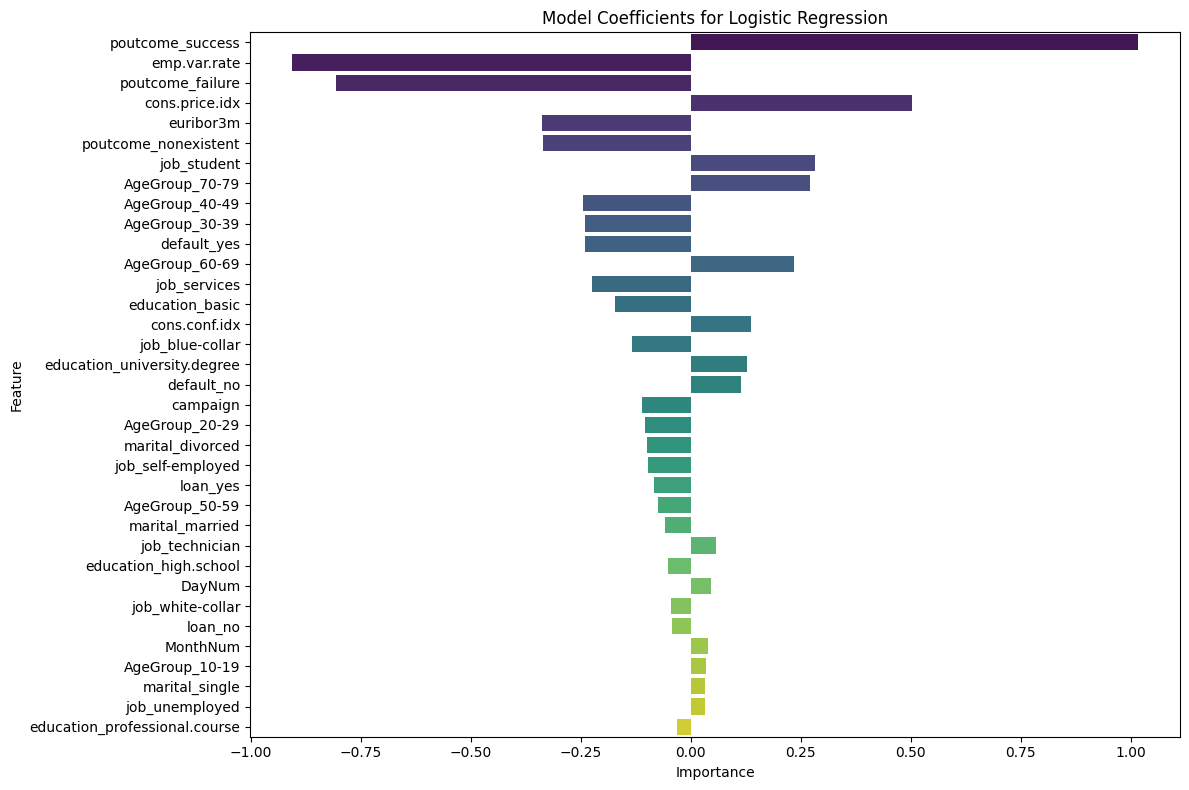

1
Training KNN model...


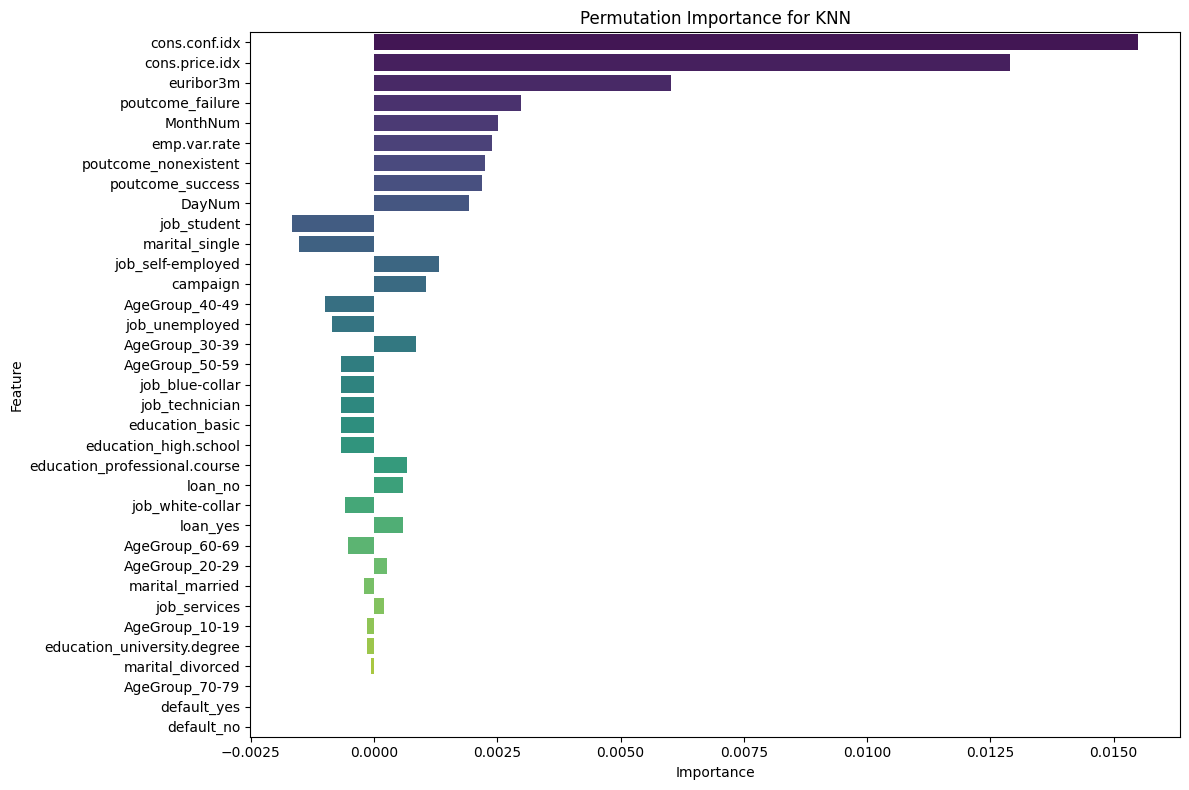

2
Training Decision Tree model...


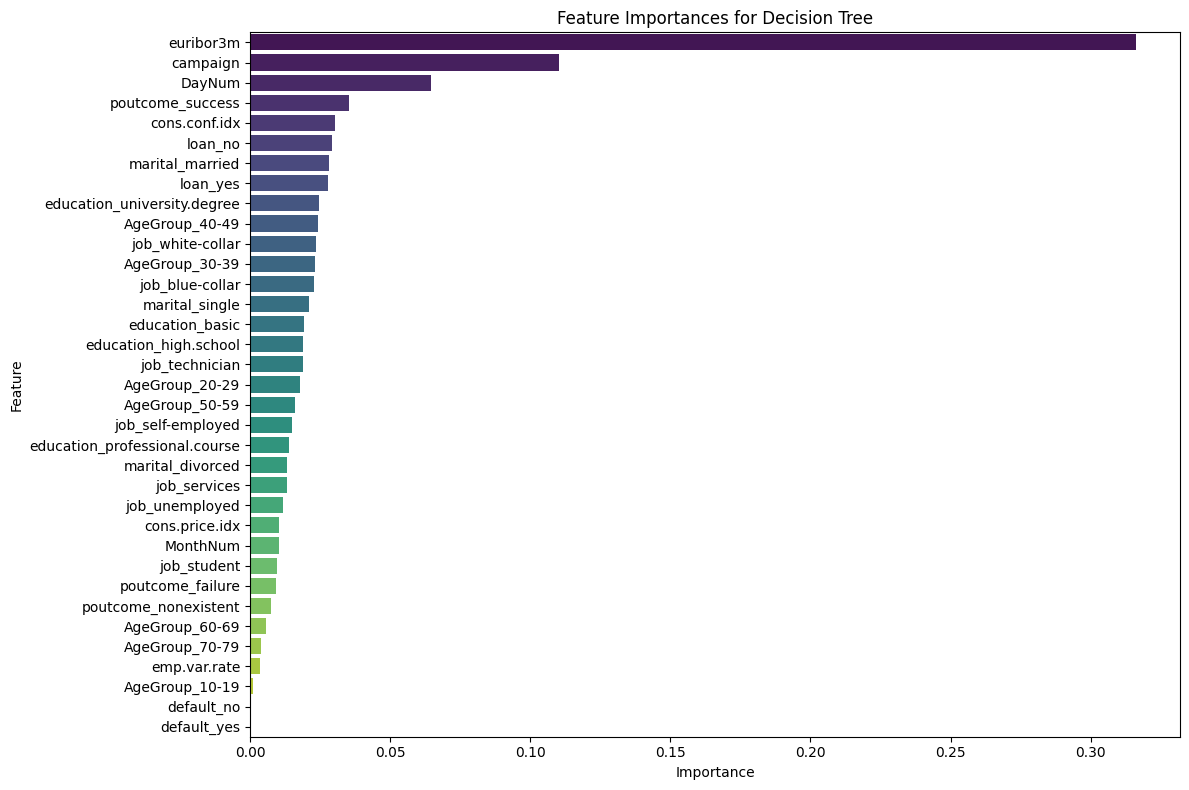

3
Training SVM model...


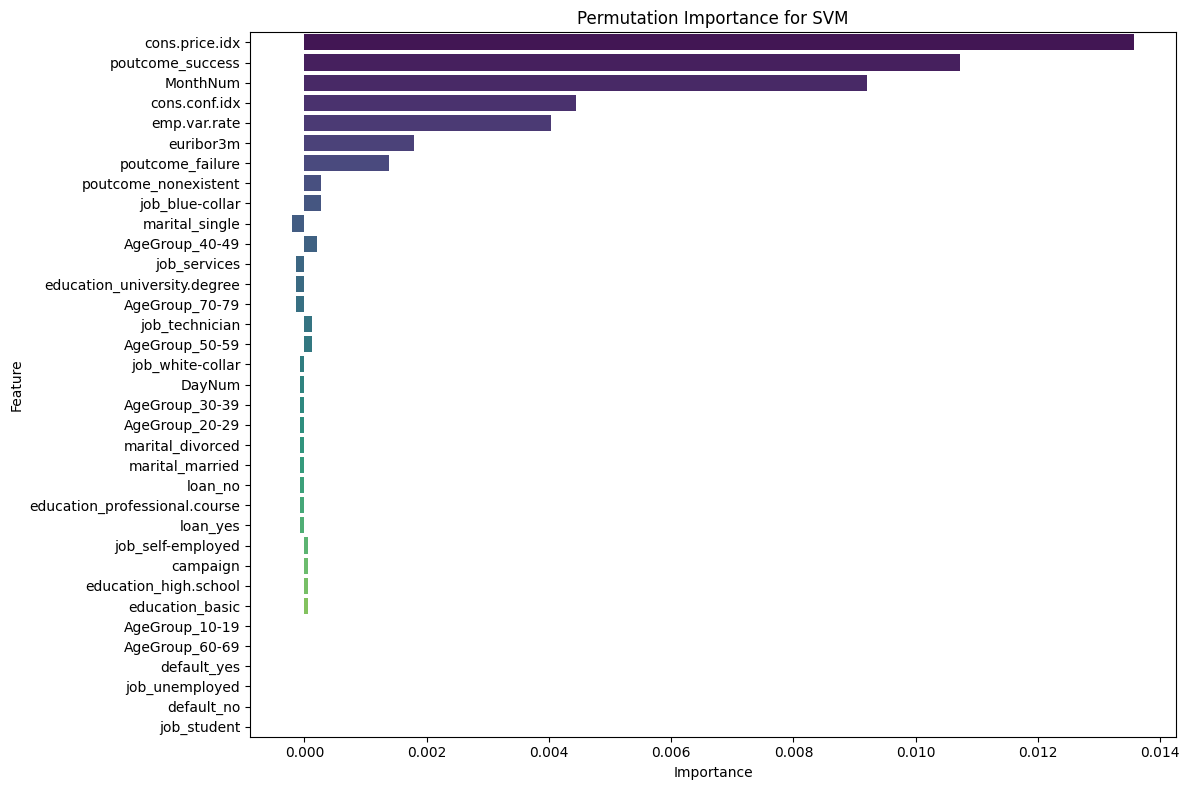


Summary of Model Performance:
                 Model  Train Time  Train Accuracy  Test Accuracy   
0  Logistic Regression    0.351165        0.889624       0.892243  \
1                  KNN    0.108506        0.905027       0.881255   
2        Decision Tree    0.238517        0.981023       0.845512   
3                  SVM   38.450436        0.892537       0.892904   

   Yes class Precision  No class Precision  Yes class Recall  No class Recall   
0             0.680328            0.899316          0.184035         0.988274  \
1             0.505643            0.904655          0.248337         0.967078   
2             0.351291            0.911601          0.347007         0.913109   
3             0.701299            0.898949          0.179601         0.989627   

   Yes class F1 Score  No class F1 Score  
0            0.289703           0.941699  
1            0.333086           0.934825  
2            0.349136           0.912354  
3            0.285966           0.942111  


In [32]:
from scipy.stats import uniform, randint
results_no_optimization = []
X_test_processed = preprocessor.fit_transform(X_test)
data = {'Model Name':['Logistic Regression','KNN','Decision Tree','SVM'],
        'Model':[LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),SVC()]}

for i, model_name in enumerate(data['Model Name']):
    print(i)
    print(f"Training { model_name} model...")
    pipe = Pipeline([('transformer', preprocessor),
                   ('model', data['Model'][i])])
    start = time.time()
    pipe.fit(X_train,y_train)
    end = time.time()
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    train_time = end-start
    results_no_optimization.append({
        'Model': data['Model Name'][i],
        'Train Time': train_time,
        'Train Accuracy': train_score,
        'Test Accuracy': test_score,
        'Yes class Precision': precision_score(y_test, y_test_pred, pos_label='yes'),
        'No class Precision': precision_score(y_test, y_test_pred, pos_label='no'),
        'Yes class Recall': recall_score(y_test, y_test_pred, pos_label='yes'),
        'No class Recall': recall_score(y_test, y_test_pred, pos_label='no'),
        'Yes class F1 Score': f1_score(y_test, y_test_pred, pos_label='yes'),
        'No class F1 Score': f1_score(y_test, y_test_pred, pos_label='no')
    })
    if hasattr(pipe.named_steps['model'], 'feature_importances_'):
        # For tree-based models
        importances = pipe.named_steps['model'].feature_importances_
        method = 'Feature Importances'
    elif hasattr(pipe.named_steps['model'], 'coef_'):
        # For linear models (e.g., Logistic Regression, Linear SVC)
        importances = pipe.named_steps['model'].coef_[0]  # Take absolute value
        method = 'Model Coefficients'
    else:
        # Fallback: permutation importance for models without native importance
        perm_result = permutation_importance(pipe.named_steps['model'], X_test_processed, y_test, n_repeats=2, random_state=42)
        importances = perm_result.importances_mean
        method = 'Permutation Importance'
        
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False, key=abs)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
    plt.title(f'{method} for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()   

results_df = pd.DataFrame(results_no_optimization)

# Print results
print("\nSummary of Model Performance:")
print(results_df)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

0
Training Logistic Regression model...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
0.889977492387131
0.892374900714853
Best parameters: {'C': 0.1, 'penalty': 'l1'}
              precision    recall  f1-score   support

          no       0.90      0.99      0.94      6652
         yes       0.70      0.17      0.28       902

    accuracy                           0.89      7554
   macro avg       0.80      0.58      0.61      7554
weighted avg       0.87      0.89      0.86      7554



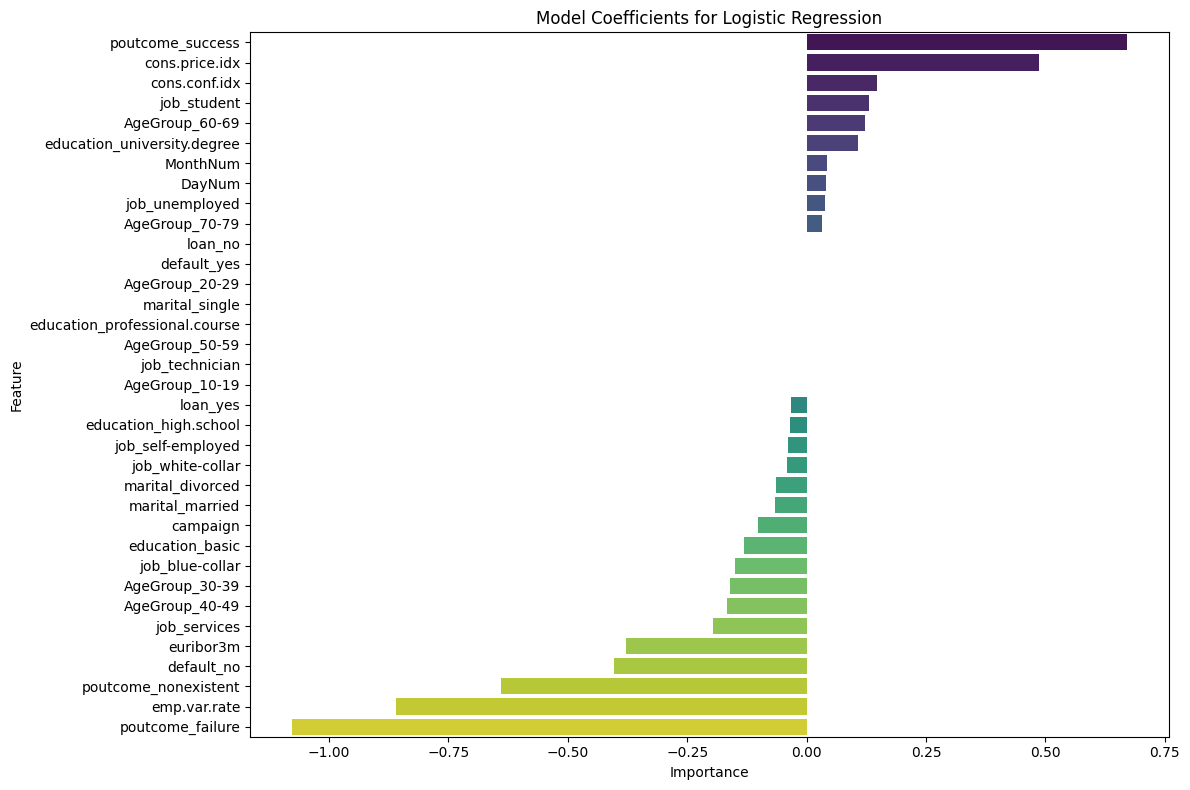

1
Training KNN model...
Fitting 2 folds for each of 24 candidates, totalling 48 fits
0.8924930491195552
0.8888006354249405
Best parameters: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      6652
         yes       0.62      0.18      0.28       902

    accuracy                           0.89      7554
   macro avg       0.76      0.58      0.61      7554
weighted avg       0.87      0.89      0.86      7554



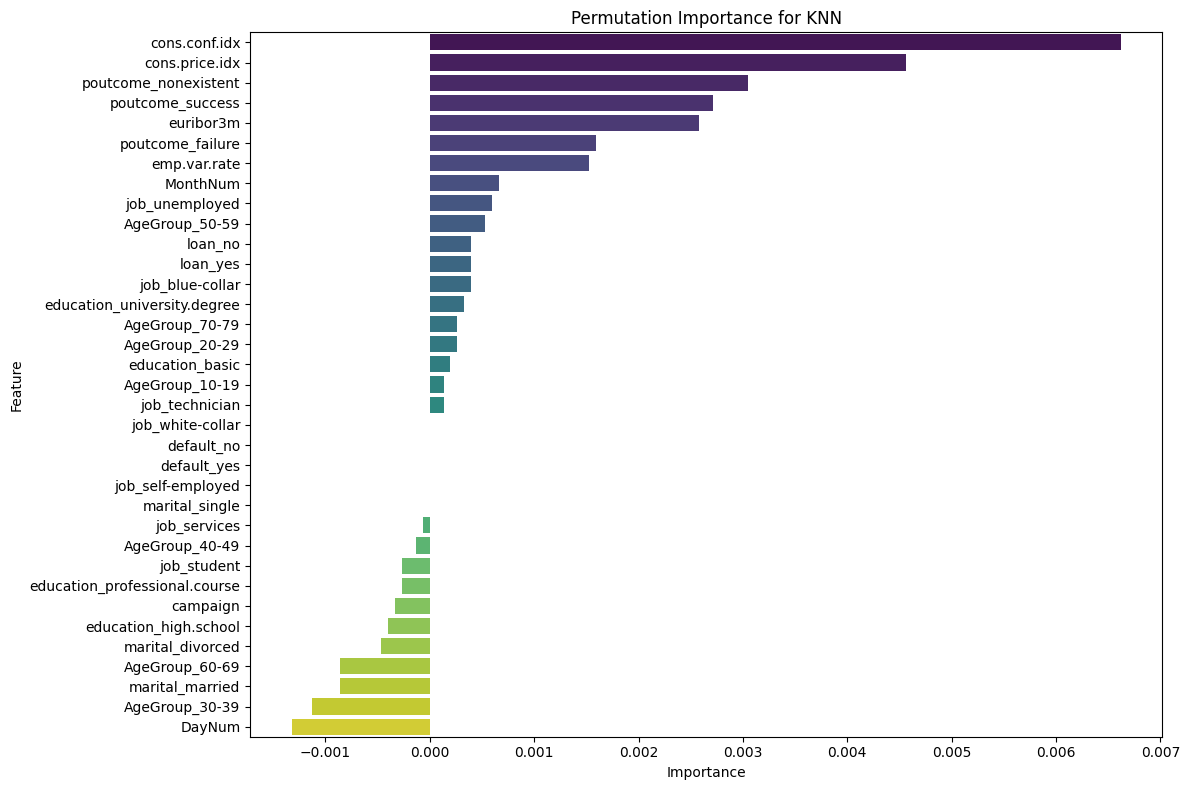

2
Training Decision Tree model...
Fitting 2 folds for each of 135 candidates, totalling 270 fits
0.8900657575356371
0.8925072809107758
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

          no       0.90      0.99      0.94      6652
         yes       0.70      0.17      0.28       902

    accuracy                           0.89      7554
   macro avg       0.80      0.58      0.61      7554
weighted avg       0.87      0.89      0.86      7554



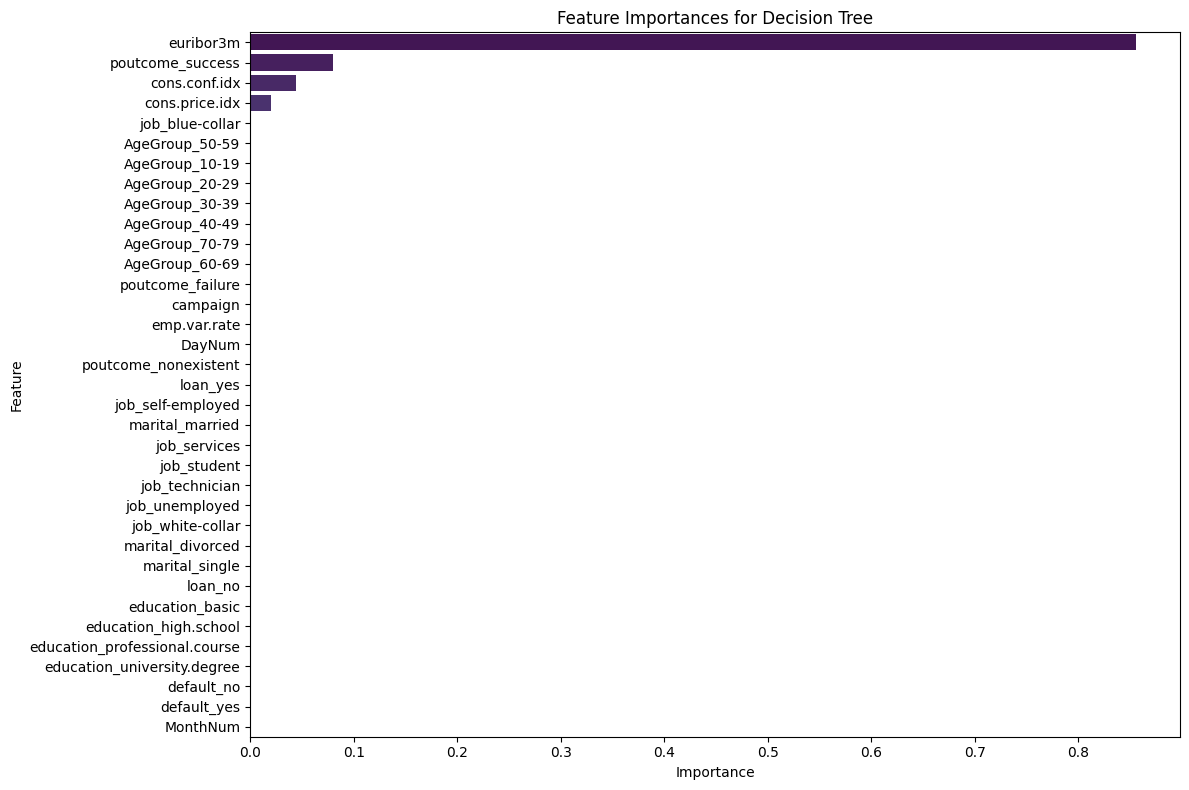

3
Training SVM model...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
0.8883004545655148
0.8913158591474716
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          no       0.90      0.99      0.94      6652
         yes       0.65      0.19      0.30       902

    accuracy                           0.89      7554
   macro avg       0.78      0.59      0.62      7554
weighted avg       0.87      0.89      0.86      7554



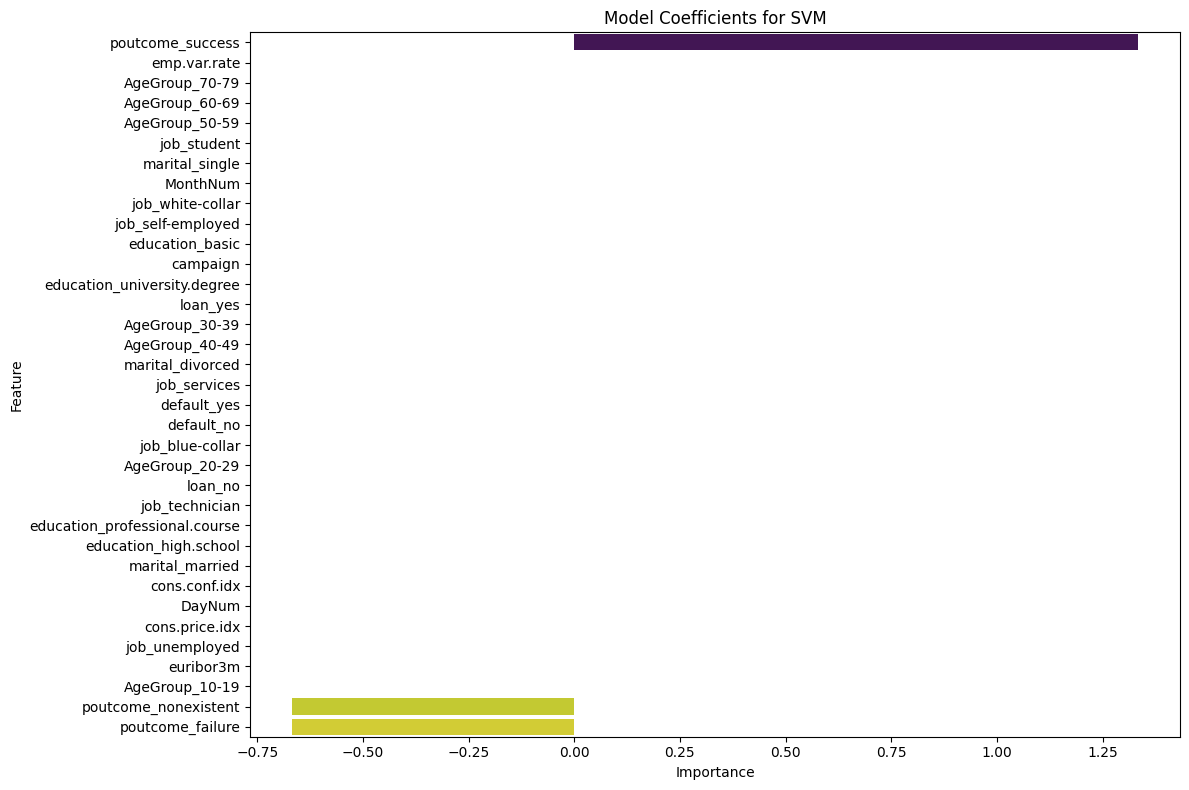


Summary of Model Performance:
                 Model                                    Best Parameters   
0  Logistic Regression                        {'C': 0.1, 'penalty': 'l1'}  \
1                  KNN  {'metric': 'euclidean', 'n_neighbors': 20, 'we...   
2        Decision Tree  {'criterion': 'entropy', 'max_depth': 3, 'min_...   
3                  SVM   {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}   

   Best CV Accuracy Score  Test Accuracy Score  Yes Class Precision   
0                0.889845             0.892375             0.697778  \
1                0.886050             0.888801             0.618321   
2                0.889580             0.892507             0.702703   
3                0.888301             0.891316             0.650558   

   No Class Precision  Yes Class Recall  No Class Recall  Yes Class F1 Score   
0            0.898349          0.174058         0.989778            0.278616  \
1            0.898519          0.179601         0.984967           

In [36]:
# To improve the model:
# 1. Use of Grid Search CV
# Calculate precision, recall, F1 score and accuracy for both Yes and No classes
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.fit_transform(X_test)
results = []
data = {'Model Name':['Logistic Regression','KNN','Decision Tree','SVM'],
        'Model':[LogisticRegression(solver='liblinear'),KNeighborsClassifier(),DecisionTreeClassifier(),SVC()], 
        'Params':[{'C':[0.01,0.1,1,10,100], 'penalty':['l1','l2']},{'n_neighbors': [3, 12,15,20,22,25],'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']},{'criterion': ['gini', 'entropy', 'log_loss'],'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},{'C': [0.1, 10],'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}]}

for i, model_name in enumerate(data['Model Name']):
    print(i)
    print(f"Training { model_name} model...")
    grid = GridSearchCV(data['Model'][i], data['Params'][i], cv=2, scoring = 'accuracy', verbose = 1)
    grid.fit(X_train_processed, y_train)
    y_train_pred = grid.predict(X_train_processed)
    y_test_pred = grid.predict(X_test_processed)
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    print(train_score)
    print(test_score)
    print("Best parameters:", grid.best_params_)
    print(classification_report(y_test, y_test_pred))  
    if hasattr(grid.best_estimator_, 'feature_importances_'):
        # For tree-based models
        importances = grid.best_estimator_.feature_importances_
        method = 'Feature Importances'
    elif hasattr(grid.best_estimator_, 'coef_'):
        # For linear models (e.g., Logistic Regression, Linear SVC)
        importances = grid.best_estimator_.coef_[0]  
        method = 'Model Coefficients'
    else:
        # Fallback: permutation importance for models without native importance
        perm_result = permutation_importance(grid.best_estimator_, X_test_processed, y_test, n_repeats=2, random_state=42)
        importances = perm_result.importances_mean
        method = 'Permutation Importance'
        
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
    plt.title(f'{method} for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()    
       
    results.append({
        'Model': data['Model Name'][i],
        'Best Parameters': grid.best_params_,
        'Best CV Accuracy Score': grid.best_score_,
        'Test Accuracy Score': test_score,
        'Yes Class Precision': precision_score(y_test, y_test_pred, pos_label='yes'),
        'No Class Precision': precision_score(y_test, y_test_pred, pos_label='no'),
        'Yes Class Recall': recall_score(y_test, y_test_pred, pos_label='yes'),
        'No Class Recall': recall_score(y_test, y_test_pred, pos_label='no'),
        'Yes Class F1 Score': f1_score(y_test, y_test_pred, pos_label='yes'),
        'No Class F1 Score': f1_score(y_test, y_test_pred, pos_label='no')
    })
results_df = pd.DataFrame(results)

# Print results
print("\nSummary of Model Performance:")
print(results_df)
#data['Train Time'].append(train_time)
#data['Train Accuracy'].append(svc_train_score)
#data['Test Accuracy'].append(svc_test_score)

# Conclusion/Findings
Our objective was to:
1. Prioritize models with high precision for the "Yes" class
2. Avoid costs on calling customers who will say "No"
3. Reduce lost opportunity by identifying customers as "No" when they could be "Yes"

## Looking at the above results:

### All models have accuracy slightly better or equal to baseline

### Choice 1: Logistic Regression
~70% precision - when it predicts "Yes" it is right 70% of the time, minimizing identifying "No"s
Excellent No Recall 99% - When the model predicts No, there are very few false positives i.e. Yes classified as "No"
Low Yes recall 17.4% - When the model predicts "Yes", there are false positives
Simple and fast to deploy and Scale

### Choice 2: Decision Tree
~70.3% precision - when it predicts "Yes" it is right 70.3% of the time, minimizing identifying "No"s
Excellent No Recall 99% - When the model predicts No, there are very few false positives i.e. Yes classified as "No"
~17.3% recall - comparable to Logistic Regression model
Shallow Tree - fast and interpretable

### Choice 3: SVM
~65% precision - when it predicts "Yes" it is right 65% of the time, minimizing identifying "No"s
~19.5% recall - slightly better than the Logistic Regression and Decision Tree models
Excellent "No" recall 98.6% minimizing false positives
Longer training times.

### Not a choice: KNN:
Lowest precision 61.8% indicating calls will be made to uninterested customers
Lowest accuracy 88.88%

### Factors influencing the acceptance of the offer:

### Economic and Social factors tend to influence the decision of the consumer
1. Economic factors such as Consumer price index which is a direct indicator of the inflation is seen to influence the decision- at a higher inflation rate, consumers want to spend less and invest more and are likely to accept the offer. 
2. Euribor High Euribor(Euro Interbank Offered Rate) rate indicates stringent monetary policies and stress in the banking system, and people tend to invest less. 
3. Employment variation rate indicates change in employment rate. If this value is negative, it indicates that people are losing job. It seems to have a negative correlation with the Acceptance indicating that as employment improves, people may not have time to look at the offers or make investments.  
4. Consumer Confidence index - Higher value indicates that the customer may invest in the offer

### Previous acceptance or rejection also seems to be influencing the decision.
If a customer has accepted previous investment offers they are likely to accept it again.

### Students, unemployed or retired - above the age of 60 seem more likely to invest - looking to make money
Age group 20-59 seems to be declining the offer probably because they may have loans on their house or other things that they need to pay off.

### Those with university degrees seem more likely to invest as they may have bank balance due to better paying jobs





##### Questions